In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
ae_loss = 'emd'

save_synthetic_samples = True
save_model = True
saver_step = 10

class_name = raw_input('Give me the class type: ').lower()
ae_id = raw_input('Give me the AE/experiment ID: ').lower()
cmp_type = raw_input('Comparison Type ("best" epoch vs. "max_min" epoch): ').lower()

syn_id = shape_net_category_to_synth_id()[class_name]

experiment_name = '_'.join(['nb_wgan_gp_ae', ae_id, ae_loss, class_name, str(n_pc_samples), cmp_type, 'epoch'])

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds'

train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/gan/nb_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir);

Give me the class type: chair
Give me the AE/experiment ID: 11
Comparison Type ("best" epoch vs. "max_min" epoch): best


In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [6]:
ae_help = relevant_class(ae_loss)

In [7]:
# Load Auto-Encoder
ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
bneck = ae.bottleneck_size
assert(ae_help.experiment_id_to_bneck[int(ae_id)] == bneck) 

if cmp_type.startswith('best'):
    load_epoch, _ = ae_help.best_epochs[bneck]
    print load_epoch
elif cmp_type.startswith('max'):
    load_epoch, _ = ae_help.max_min_epochs[bneck]
else:
    assert(False)
    saved_epochs = read_saved_epochs(ae_conf.train_dir)
    load_epoch = saved_epochs[-1]

ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

940
Model restored in epoch 940.


In [8]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [17]:
# reconstructed = ae.decode(latent_codes)
# save_dir = osp.join(top_data_dir, 'OUT/icml/ae_reconstructed_point_clouds')
# create_dir(save_dir)
# save_file = osp.join(save_dir, 'ae_' + ae_id + '_2048pts_' + ae_loss + '_' + cmp_type)
# np.savez(save_file, reconstructed)

In [ ]:
# TODO : make GAN conf.
init_lr = 0.0001
batch_size = 50

noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = ae.bottleneck_size
max_epochs = 500

n_syn_samples = training_data.num_examples  # Same number as original GT data.
n_out = [ae.bottleneck_size]

lam = 10
beta = 0.5
disc_kwargs = {'b_norm': False}
reset_tf_graph()
gan = RawGAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,\
                latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                beta=beta, disc_kwargs=disc_kwargs)


1 (-0.10268921057383219, 0.030264575517287961)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


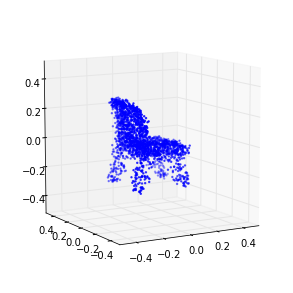

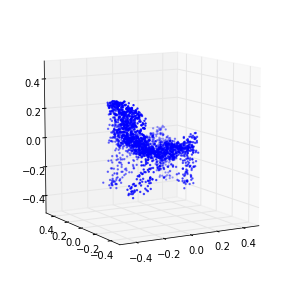

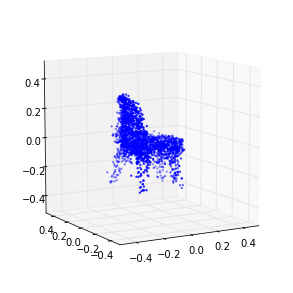

2 (-0.96433351569705539, 0.017602915220238543)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


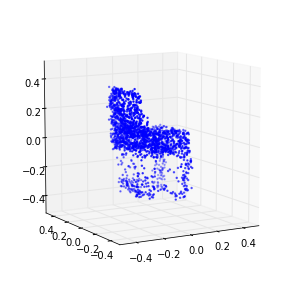

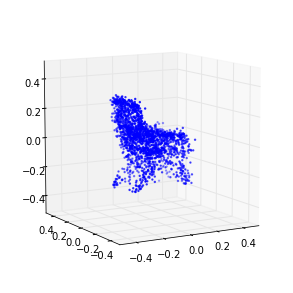

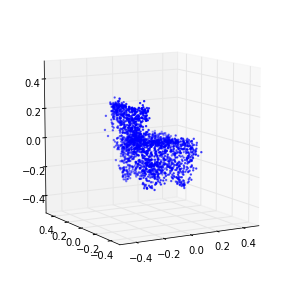

3 (-0.88106735856444751, -0.13199756349678393)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


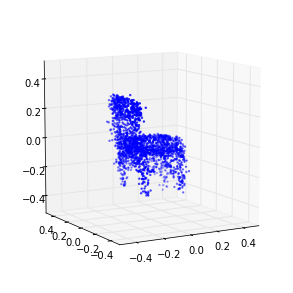

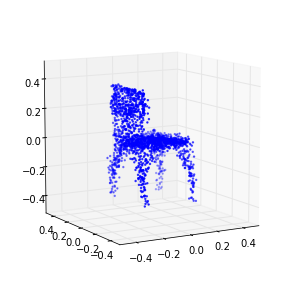

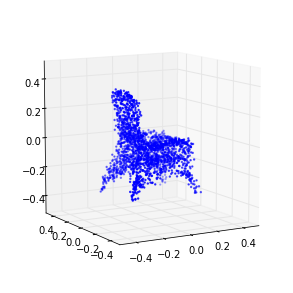

4 (-0.82098773497122302, -0.042807524540910018)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


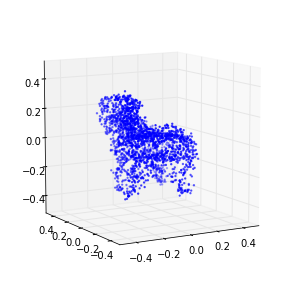

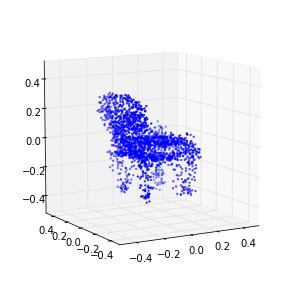

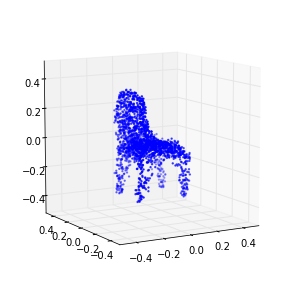

5 (-0.79477830860349863, 0.080192762944433421)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


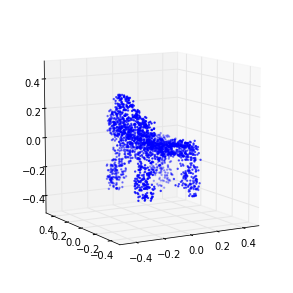

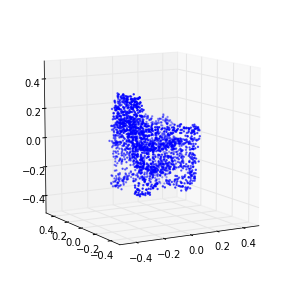

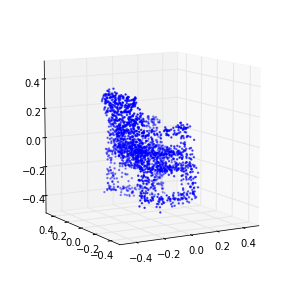

6 (-0.78346081265696776, 0.16079926270025749)
7 (-0.7848987738291423, 0.18068974796268675)
8 (-0.78190667320180818, 0.16422299681990235)
9 (-0.7724280141018055, 0.15587462070915434)
10 (-0.76298694080776641, 0.11623085248801443)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


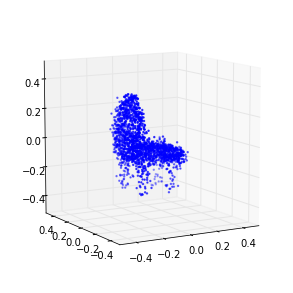

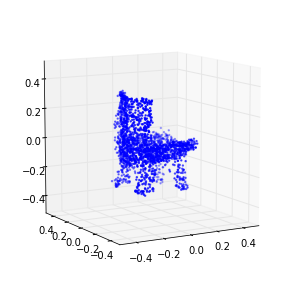

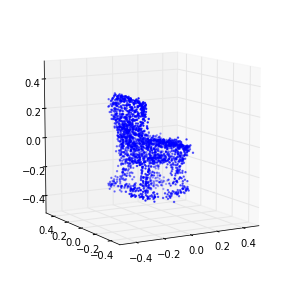

11 (-0.7450618518723382, 0.080497512593865395)
12 (-0.72294270815672701, 0.042836923186701757)
13 (-0.69350573045236097, 0.02655414489304854)
14 (-0.66986631596529922, 0.02355005585209087)
15 (-0.64242063098483615, 0.009518552381821253)
16 (-0.61680978359999483, -0.015878429964046786)
17 (-0.58465283579296534, -0.044846609062342731)
18 (-0.55748155448171832, -0.039140613404689009)
19 (-0.52005061705907185, -0.039246543690010356)
20 (-0.4938598350242332, -0.060466289037355674)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


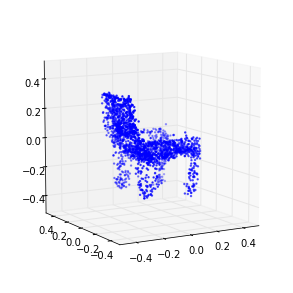

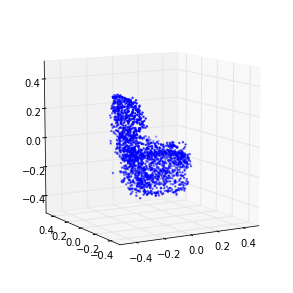

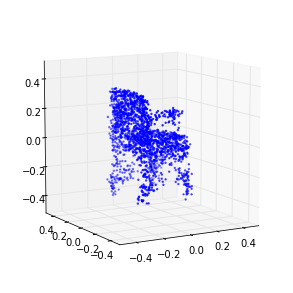

21 (-0.46915408284575849, -0.082846616912219256)
22 (-0.44300680359204608, -0.05353923892188403)
23 (-0.41739820970429314, -0.11504738889979543)
24 (-0.39476379487249585, -0.088216177670768017)
25 (-0.38088245237315144, -0.057417894092698894)
26 (-0.36364836736961648, -0.09850767896407181)
27 (-0.34730719901897289, -0.091092660057323957)
28 (-0.33516663710276284, -0.069777983568470786)
29 (-0.32496862279044259, -0.057233618624094457)
30 (-0.3207835246015478, -0.074900353327393532)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


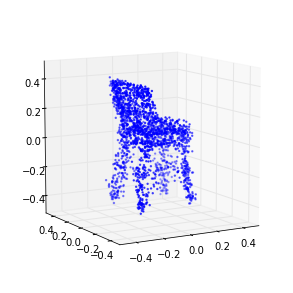

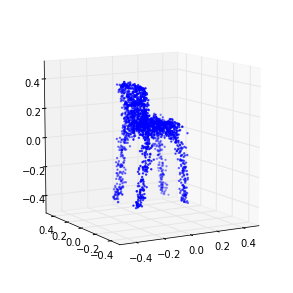

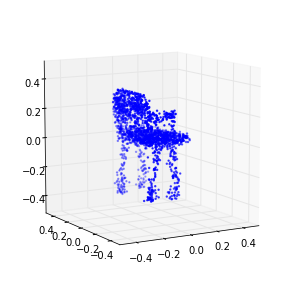

31 (-0.30964615576797061, -0.039676896261948126)
32 (-0.30681408776177299, -0.04713614943816706)
33 (-0.30244997276200186, -0.08427368631344978)
34 (-0.29904494329735087, -0.08149122431253393)
35 (-0.29402137255227123, -0.043640131337775126)
36 (-0.29569391475783452, -0.10652749583608022)
37 (-0.29206303634025432, -0.10697533928409771)
38 (-0.28416358199384478, -0.089382131773702522)
39 (-0.28329042582600206, -0.10378714040335682)
40 (-0.28299344005408111, -0.1408906503132096)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


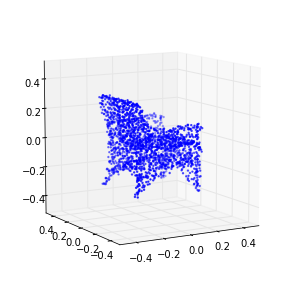

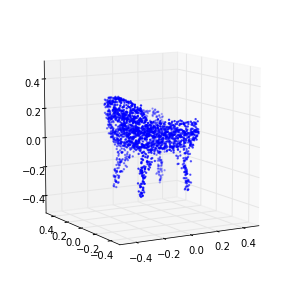

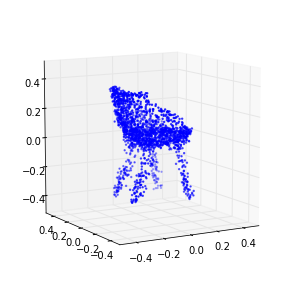

41 (-0.2760465078883701, -0.12419554053081407)
42 (-0.27353114077338464, -0.11756165456716661)
43 (-0.26821607086393567, -0.12067926385336453)
44 (-0.26488444937600031, -0.10148436231193719)
45 (-0.26503459943665397, -0.140057690165661)
46 (-0.25715305451993586, -0.14241238987004315)
47 (-0.25944545898172588, -0.12253707398970921)
48 (-0.25602225219761882, -0.15376501033703485)
49 (-0.2494492009834007, -0.15679176758836816)
50 (-0.24917020786691596, -0.14051931434207493)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


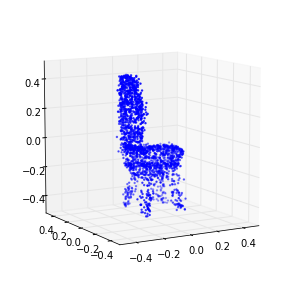

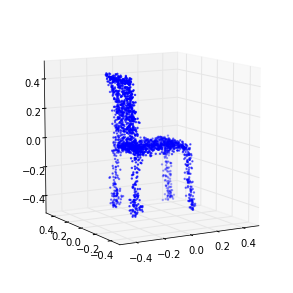

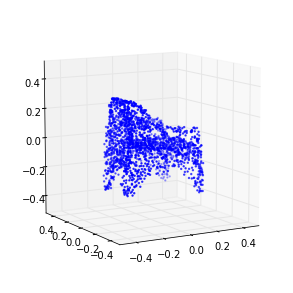

51 (-0.24512172738711038, -0.14153156484718676)
52 (-0.24359914086483142, -0.1644894254428369)
53 (-0.24040509031878576, -0.15397265774232369)
54 (-0.24020444485876297, -0.1554724804505154)
55 (-0.23744138468194892, -0.17818308594050231)
56 (-0.23314481443829008, -0.16515874448749754)
57 (-0.23535241495679926, -0.15663820670710671)
58 (-0.23108668161763085, -0.17281914861113937)
59 (-0.22940419912338256, -0.17097102243591239)
60 (-0.22658378492902825, -0.16144285682174894)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


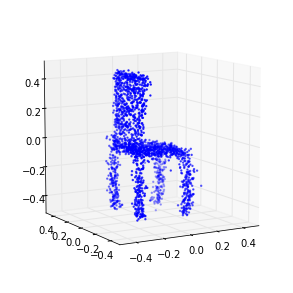

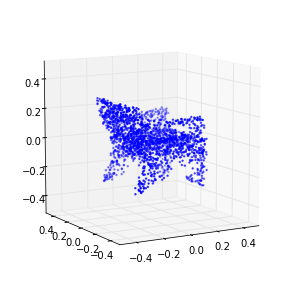

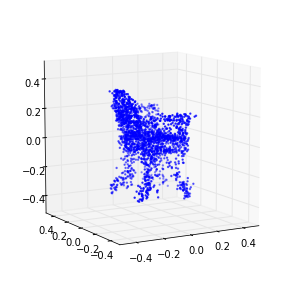

61 (-0.22891148350856921, -0.20105121615860197)
62 (-0.22581909585882115, -0.17834089392865146)
63 (-0.22644352443792201, -0.19283550867327937)
64 (-0.22515796180124636, -0.20304949002133477)
65 (-0.22398029157408961, -0.19898684267644529)
66 (-0.22045565766316874, -0.1983841332020583)
67 (-0.21896683601317582, -0.20459647807810041)
68 (-0.21961082496024945, -0.20364578068256378)
69 (-0.2222453768606539, -0.20260096258587307)
70 (-0.22032423218091329, -0.19777859250704447)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


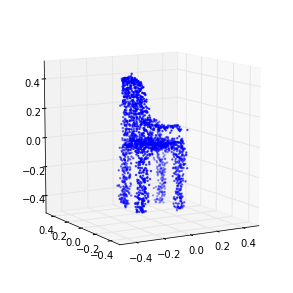

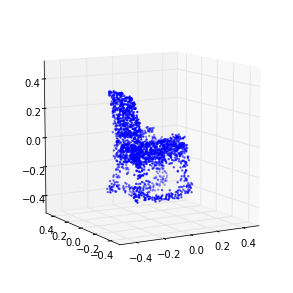

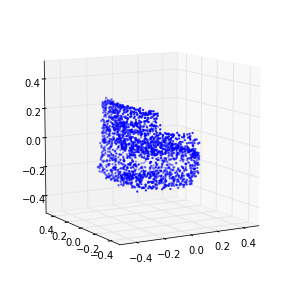

71 (-0.22173840999603273, -0.21056312267427091)
72 (-0.22012064225143857, -0.23197300566567314)
73 (-0.21856617883399682, -0.20283205945182731)
74 (-0.21614153219593896, -0.22673842200526484)
75 (-0.21790169146325852, -0.21114394317070642)
76 (-0.21859317267382586, -0.20570864169685929)
77 (-0.21982602609528434, -0.2373211681842804)
78 (-0.21538148202277996, -0.21626736278887149)
79 (-0.21657018087528371, -0.21789693059744658)
80 (-0.21429907105587148, -0.20766880501199653)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


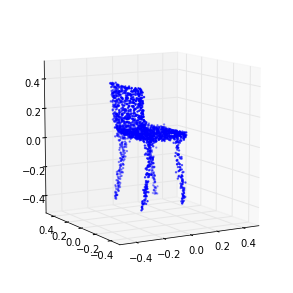

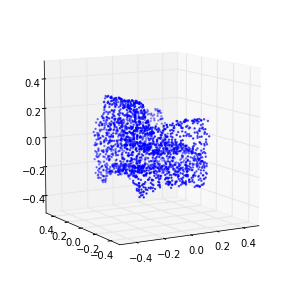

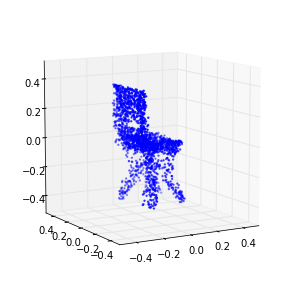

81 (-0.21312503362143481, -0.25020230257952653)
82 (-0.2150660934271636, -0.23036335850203479)
83 (-0.21355155695367742, -0.21446593298956199)
84 (-0.2123421718676885, -0.22526973651515114)
85 (-0.21217437298209579, -0.25200704954288622)
86 (-0.20739919002409335, -0.22946504089567396)
87 (-0.20825936639750445, -0.22780900089829056)
88 (-0.20772047826537379, -0.24658380062491805)
89 (-0.20639222319479342, -0.23316323757171631)
90 (-0.20969318007981336, -0.22224823523450782)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


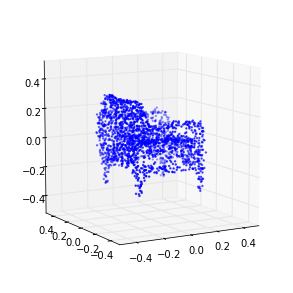

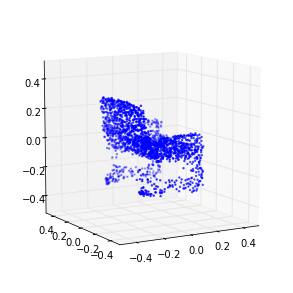

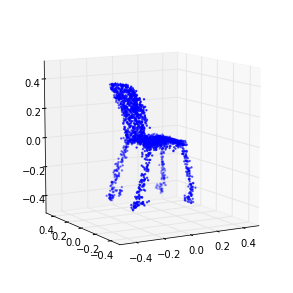

91 (-0.2072744690157749, -0.22663151941917561)
92 (-0.20640053324125432, -0.2445980062087377)
93 (-0.20799277513115494, -0.22075419348699074)
94 (-0.20578783916102517, -0.23987566265794966)
95 (-0.20654584732320574, -0.22868178122573429)
96 (-0.20494938117486458, -0.2345347989488531)
97 (-0.20750550936769557, -0.22726522275695094)
98 (-0.20653104699320263, -0.22853444682227242)
99 (-0.20302190891018621, -0.22500906470749113)
100 (-0.20636702969118401, -0.20605566435390049)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


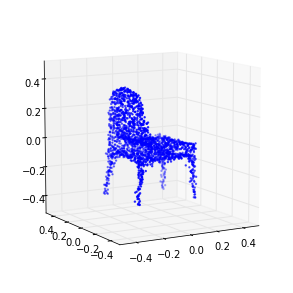

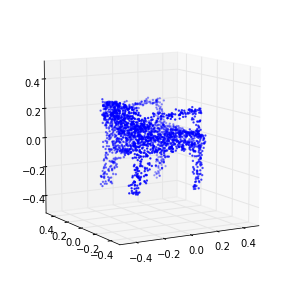

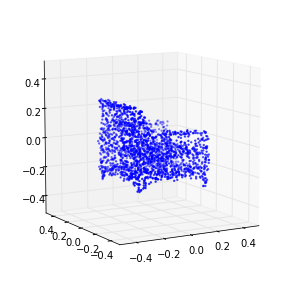

101 (-0.20444480346308813, -0.22691161102718777)
102 (-0.20681417253282336, -0.24374576299278825)
103 (-0.20398106558455362, -0.24130075286935876)
104 (-0.20555730495187971, -0.22219103078047434)
105 (-0.20439072251319884, -0.21501686893127583)
106 (-0.20332845339068659, -0.23223003524321098)
107 (-0.20482654229358391, -0.21166340123724053)
108 (-0.20366665461549052, -0.21931006952568335)
109 (-0.20419972373379602, -0.22902941151901526)
110 (-0.20218772308693991, -0.21053000346378045)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.


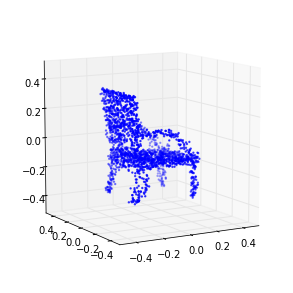

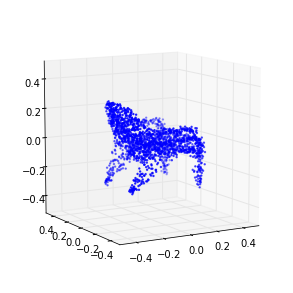

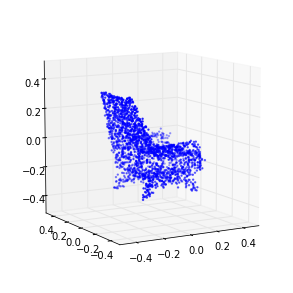

111 (-0.1995368010467953, -0.22127817184836776)
112 (-0.20075292383079177, -0.22089793063976146)
113 (-0.19931581362530038, -0.21959694723288217)
114 (-0.20065987397123267, -0.20256531128176936)
115 (-0.19833038725234844, -0.21401538782649571)
116 (-0.20197478345146885, -0.21754632669466514)
117 (-0.19816971978655568, -0.20401345579712479)
118 (-0.19850335419178008, -0.21506824923886192)
119 (-0.19797402763808214, -0.21082649931863504)
120 (-0.1987119217713674, -0.20959346272327281)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.


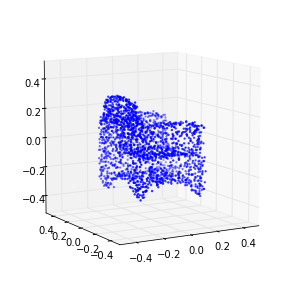

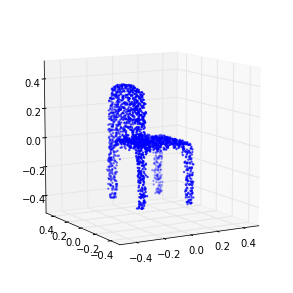

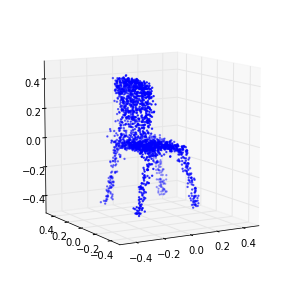

121 (-0.19617143394770445, -0.2099074677184776)
122 (-0.19631271847972162, -0.19790622371214409)
123 (-0.19283038874467215, -0.21362905756190972)
124 (-0.19562157436653418, -0.20924745389708765)
125 (-0.19566192715256303, -0.23472012413872612)
126 (-0.19241327991088231, -0.21266909992253338)
127 (-0.19535388665066825, -0.20879132990483884)
128 (-0.19446882793196926, -0.22423042025831011)
129 (-0.1952565583365935, -0.21311280241718999)
130 (-0.19232627269294528, -0.20464700184486531)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-130 is not in all_model_checkpoint_paths. Manually adding it.


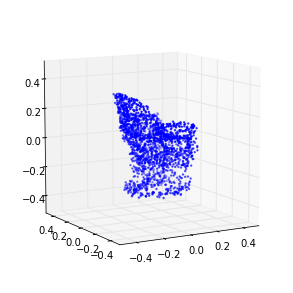

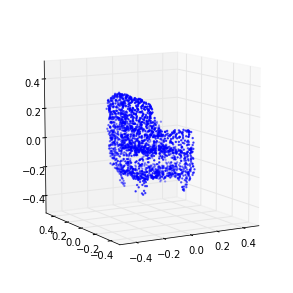

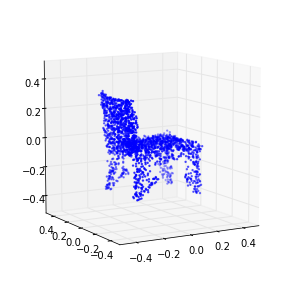

131 (-0.19040954824950959, -0.2313814604723895)
132 (-0.19405918733941185, -0.20694525208738115)
133 (-0.19116099300207914, -0.21362642060827325)
134 (-0.19393663869963751, -0.20822503666083017)
135 (-0.19146886109201997, -0.24285529995406116)
136 (-0.18977422267198563, -0.22869689486644887)
137 (-0.19016995005033635, -0.23761958490919183)
138 (-0.18987607525454628, -0.24221473214802919)
139 (-0.1872713738569507, -0.22419429101325847)
140 (-0.1894942401735871, -0.24056934537710967)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-140 is not in all_model_checkpoint_paths. Manually adding it.


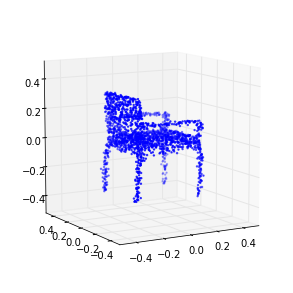

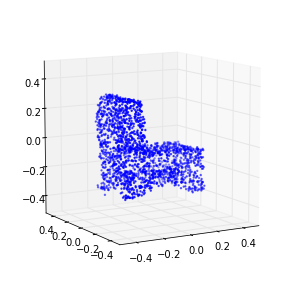

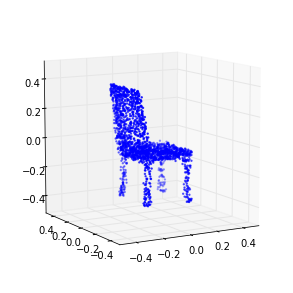

141 (-0.18628863052085595, -0.23614727678122344)
142 (-0.18740052983716682, -0.23130617815035362)
143 (-0.1863053364886178, -0.23604588376151192)
144 (-0.18906894497297427, -0.23604725356455203)
145 (-0.18776540601695024, -0.25138240666301165)
146 (-0.18915623299501561, -0.22720381562356595)
147 (-0.18694239849293673, -0.2572422844392282)
148 (-0.18909749846767496, -0.23123133127336148)
149 (-0.18644805500904718, -0.23915270412409748)
150 (-0.18861359716565521, -0.22056381625157814)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-150 is not in all_model_checkpoint_paths. Manually adding it.


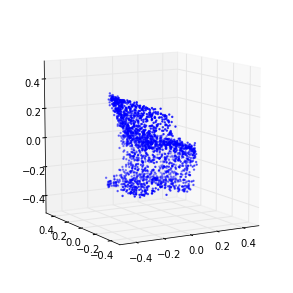

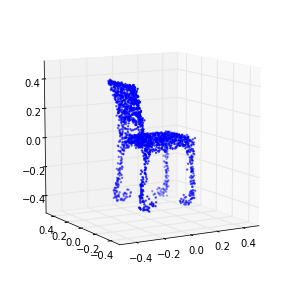

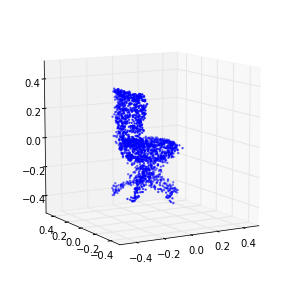

151 (-0.18624129703751316, -0.24398484329382578)
152 (-0.18434433412772638, -0.20028843427145923)
153 (-0.18546956418840974, -0.23385483081694003)
154 (-0.18456520200879487, -0.25523783984007659)
155 (-0.18445352702229112, -0.21841667206199081)
156 (-0.18748123794794083, -0.22170052318661301)
157 (-0.18710027833779652, -0.21415529924410362)
158 (-0.1835064596048108, -0.22875574783042626)
159 (-0.18465289881935826, -0.2396767360192758)
160 (-0.18666343964912274, -0.22482555939091575)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-160 is not in all_model_checkpoint_paths. Manually adding it.


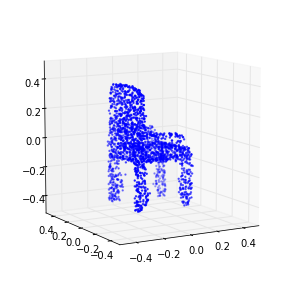

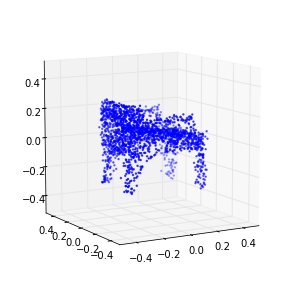

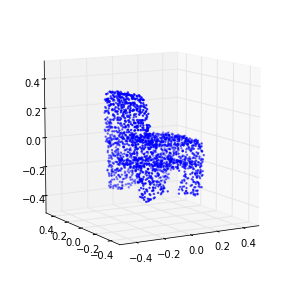

161 (-0.1874728920283141, -0.23007483725194577)
162 (-0.18541402066195453, -0.23729997928495761)
163 (-0.18387781315379673, -0.21683824007157926)
164 (-0.18361954887708029, -0.23392878969510397)
165 (-0.18667791022194757, -0.2137344347106086)
166 (-0.18431956177508391, -0.2351429197523329)
167 (-0.18347490589927745, -0.24060090824409766)
168 (-0.18315115664844159, -0.21094202001889548)
169 (-0.18426310431074214, -0.2318923732748738)
170 (-0.18362170844166367, -0.22764415983800534)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-170 is not in all_model_checkpoint_paths. Manually adding it.


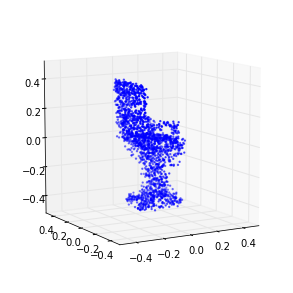

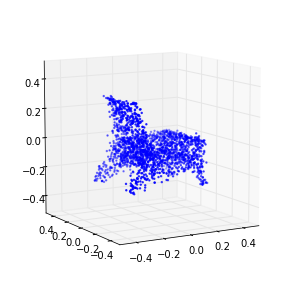

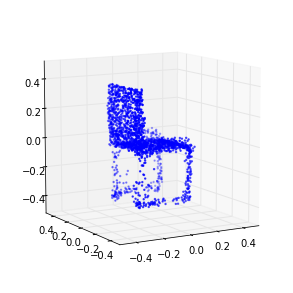

171 (-0.18300089560173177, -0.20559130884982921)
172 (-0.18309930579529868, -0.21906249390708077)
173 (-0.18059774896612873, -0.2090298307162744)
174 (-0.18442219137041657, -0.20191824988082605)
175 (-0.18656964224797709, -0.20633473164505428)
176 (-0.18318225509590572, -0.2024489199673688)
177 (-0.18193291359477573, -0.22616771470617364)
178 (-0.18406477106942071, -0.22185328823548775)
179 (-0.18312215429765208, -0.21497759112605341)
180 (-0.18550930508860836, -0.21301257113615671)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-180 is not in all_model_checkpoint_paths. Manually adding it.


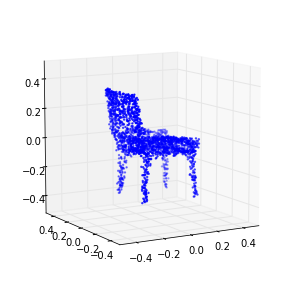

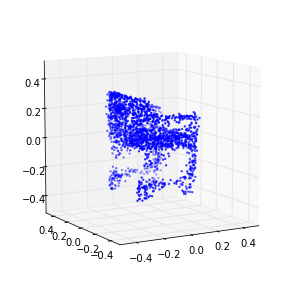

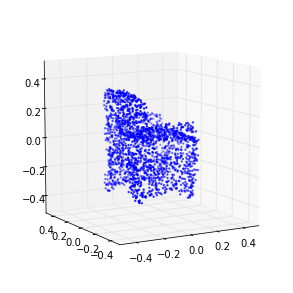

181 (-0.18151738671240983, -0.21691272932070274)
182 (-0.18514115170196252, -0.21076632208294338)
183 (-0.18375757557374459, -0.21309761868582833)
184 (-0.18090567588806153, -0.21124135785632664)
185 (-0.18445781259625046, -0.20778681061885976)
186 (-0.18135937297785723, -0.2116674471784521)
187 (-0.18222411021038337, -0.20861617282584863)
188 (-0.17755059528130071, -0.20727833719165237)
189 (-0.18177529242303636, -0.20765740507178837)
190 (-0.18176168600718182, -0.20843391065244321)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-190 is not in all_model_checkpoint_paths. Manually adding it.


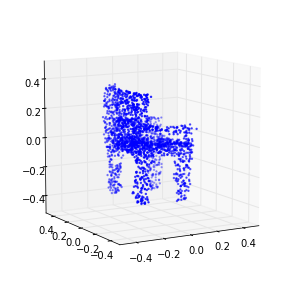

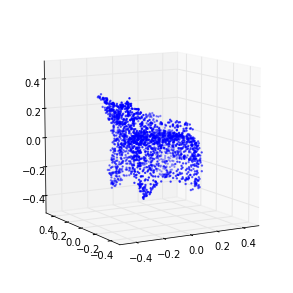

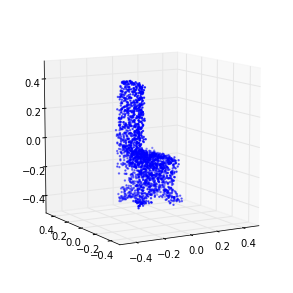

191 (-0.18067181700909579, -0.22604397160035591)
192 (-0.18052176270220016, -0.21008200612333086)
193 (-0.18061818314923181, -0.21924065770926299)
194 (-0.18162195699082481, -0.21875336987000923)
195 (-0.18453192644649083, -0.21354067932676385)
196 (-0.18154790837455678, -0.2103369837557828)
197 (-0.18315255691607793, -0.20234175909448554)
198 (-0.18053277449475394, -0.20158930619557699)
199 (-0.17769991904497145, -0.20265172863448108)
200 (-0.17886656859406719, -0.20182109210226271)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-200 is not in all_model_checkpoint_paths. Manually adding it.


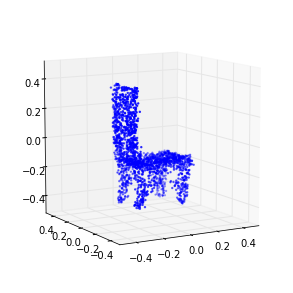

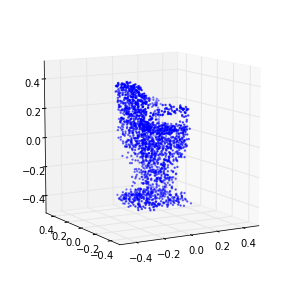

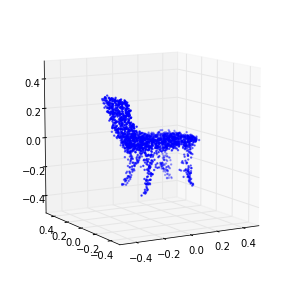

201 (-0.18271207676993476, -0.20736712879604763)
202 (-0.17987859464353986, -0.22300679319434696)
203 (-0.17835675544208951, -0.20975139792318698)
204 (-0.18289823835646665, -0.21486789208871346)
205 (-0.1789235219359398, -0.20865919247821527)
206 (-0.1763257630445339, -0.1978541976875729)
207 (-0.1796025761299663, -0.21575971720395265)
208 (-0.18219581434020291, -0.19680676140167094)
209 (-0.18202905505895614, -0.21240001916885376)
210 (-0.1786737170484331, -0.19073458788571535)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-210 is not in all_model_checkpoint_paths. Manually adding it.


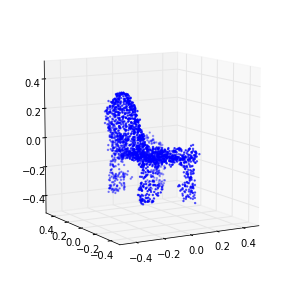

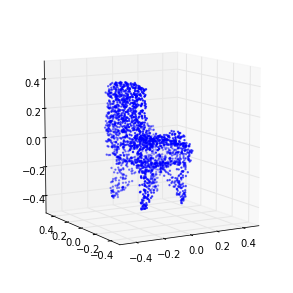

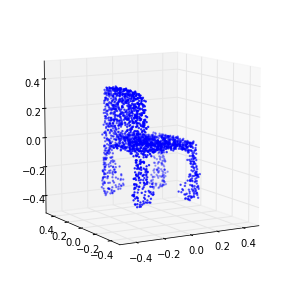

211 (-0.18154879217898404, -0.1922937168015374)
212 (-0.17734190661598134, -0.20268827897531014)
213 (-0.17650790595346028, -0.21396934986114502)
214 (-0.17612373696433173, -0.19857387465459328)
215 (-0.18015804467377838, -0.22039199537701076)
216 (-0.17943245989305001, -0.21711819425777154)
217 (-0.17723908391263749, -0.20147185579494195)
218 (-0.17810815567219698, -0.22025786174668205)
219 (-0.17936899115641911, -0.19281532477449487)
220 (-0.1774628487450105, -0.20962646658773776)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.


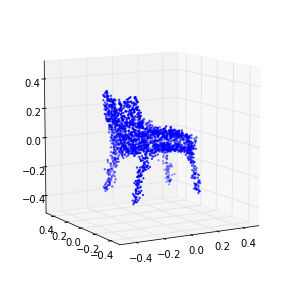

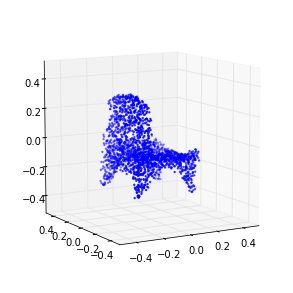

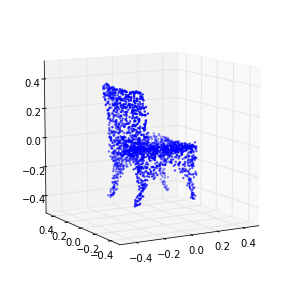

221 (-0.17848882647576156, -0.19391066663795048)
222 (-0.17757588288298359, -0.19147732246805121)
223 (-0.17846064539971174, -0.1852857216640755)
224 (-0.17808986212368363, -0.18620637500727619)
225 (-0.17529992499837169, -0.19310067704430334)
226 (-0.17721621802559606, -0.20233329247545312)
227 (-0.17581632076590151, -0.19274000326792398)
228 (-0.17911174760924445, -0.19962735584488622)
229 (-0.17817482882075839, -0.19337511559327444)
230 (-0.17893660338940443, -0.19224394526746538)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-230 is not in all_model_checkpoint_paths. Manually adding it.


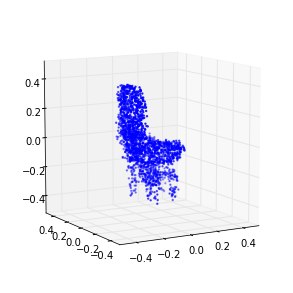

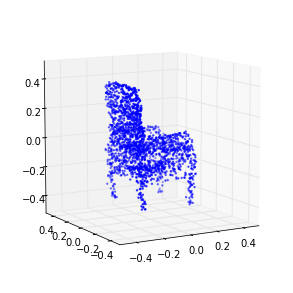

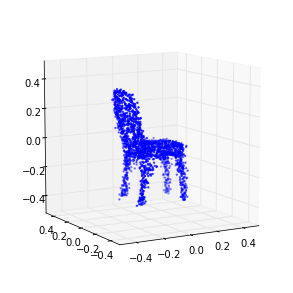

231 (-0.17594656006053641, -0.20381415607752623)
232 (-0.17629749145772722, -0.19204758990693976)
233 (-0.17639860455636625, -0.18035871839081799)
234 (-0.17598929565261912, -0.19584602945380741)
235 (-0.17950550819988603, -0.19707671856438672)
236 (-0.17574114087555143, -0.19161435244260011)
237 (-0.17619845111061025, -0.19547455509503683)
238 (-0.17441391431623035, -0.20528993176089394)
239 (-0.17581313075842681, -0.19375399638105323)
240 (-0.17650863428910574, -0.20480816231833565)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-240 is not in all_model_checkpoint_paths. Manually adding it.


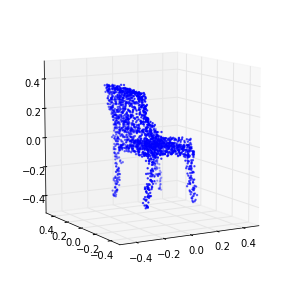

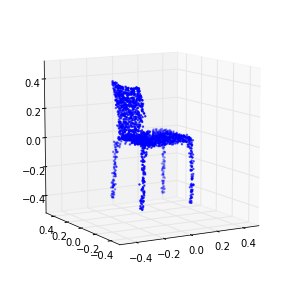

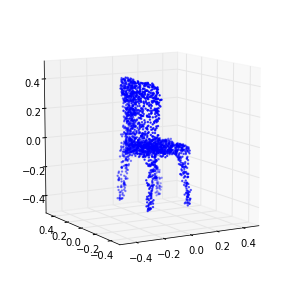

241 (-0.17663395636611515, -0.18975004664173833)
242 (-0.17942940923902723, -0.18826113751641027)
243 (-0.17414483703948833, -0.18196816852799169)
244 (-0.17526682438673796, -0.18868983481769208)
245 (-0.17238673231116047, -0.18298251264625126)
246 (-0.17140780427941568, -0.19165007383735091)
247 (-0.17559637521152144, -0.18238259465606124)
248 (-0.17652312737924081, -0.20202864596137293)
249 (-0.17482723190828606, -0.17747907174958122)
250 (-0.17417759906362604, -0.19543167617585924)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-250 is not in all_model_checkpoint_paths. Manually adding it.


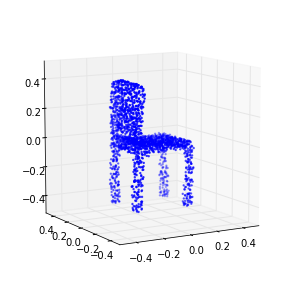

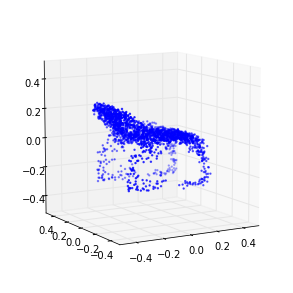

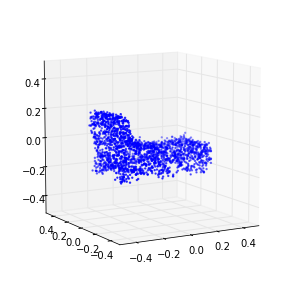

251 (-0.17209790332449806, -0.19011710308216237)
252 (-0.17444966518216662, -0.20647091556478431)
253 (-0.17426599667028145, -0.18814028358017956)
254 (-0.17606301120033971, -0.18389290460833796)
255 (-0.17638663274270516, -0.18621068254665094)
256 (-0.17422782889118901, -0.17988088561428917)
257 (-0.17759185157440327, -0.19331970038237395)
258 (-0.17336057479734773, -0.1754075343962069)
259 (-0.17678058312998879, -0.18397202480722358)
260 (-0.1749815301210792, -0.17212437507179049)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-260 is not in all_model_checkpoint_paths. Manually adding it.


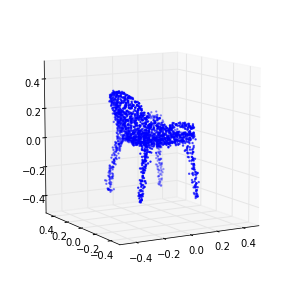

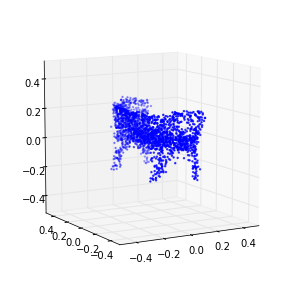

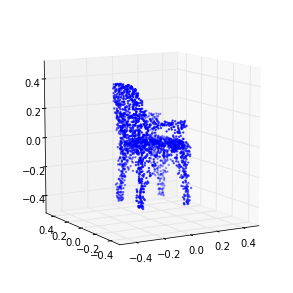

261 (-0.17236566996132885, -0.18259197694283943)
262 (-0.17505027982923721, -0.17592817213800219)
263 (-0.17184831913974549, -0.17348874277538723)
264 (-0.17039430113854231, -0.18258100361735732)
265 (-0.17637393071695609, -0.17758147915204367)
266 (-0.17294364621241887, -0.17635957896709442)
267 (-0.17438284489843581, -0.17849968594533425)
268 (-0.17539322812248159, -0.16740570631292132)
269 (-0.17309867596184766, -0.16807019793325001)
270 (-0.16897419823540583, -0.17365861601299709)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-270 is not in all_model_checkpoint_paths. Manually adding it.


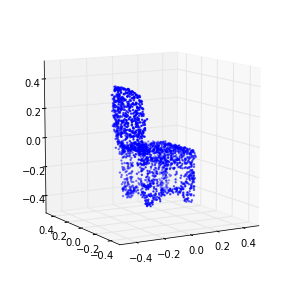

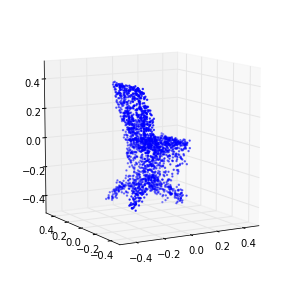

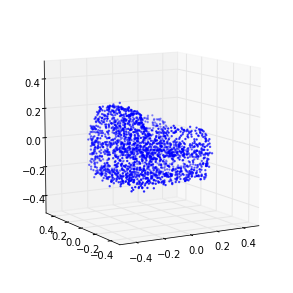

271 (-0.17163097477621503, -0.17357362089333711)
272 (-0.17135893465192228, -0.17925484312905204)
273 (-0.17416983875963424, -0.16149603713441779)
274 (-0.17275681677791807, -0.15695549520077529)
275 (-0.17127296576897302, -0.17586043311489952)
276 (-0.17498608993159401, -0.16585371367357396)
277 (-0.17211953589209802, -0.1770124363678473)
278 (-0.17109691892509107, -0.18201835839836686)
279 (-0.1710117608860687, -0.17792918643465749)
280 (-0.17685646696223153, -0.16679214327423661)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-280 is not in all_model_checkpoint_paths. Manually adding it.


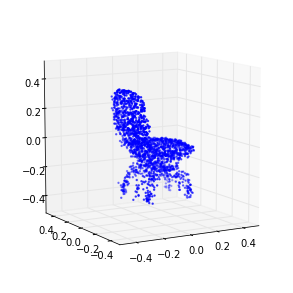

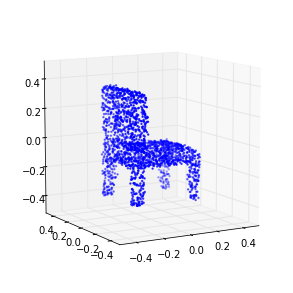

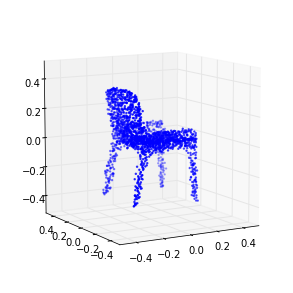

281 (-0.17483784832336285, -0.19275047216150495)
282 (-0.17308765688428171, -0.17940953677451169)
283 (-0.17351454866153224, -0.17797129794403357)
284 (-0.169458321068022, -0.16218052307764688)
285 (-0.1714158789427192, -0.1682657610487055)
286 (-0.17083419158502861, -0.15354290107885996)
287 (-0.17092245734400219, -0.174596827339243)
288 (-0.17185002019008, -0.16282780247705955)
289 (-0.17172003956856552, -0.17222716024628393)
290 (-0.17403367928884647, -0.15893126196331447)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-290 is not in all_model_checkpoint_paths. Manually adding it.


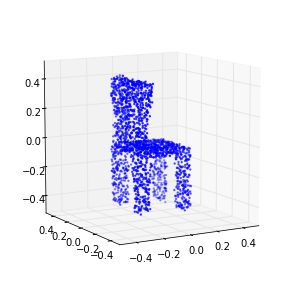

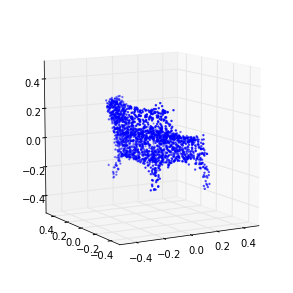

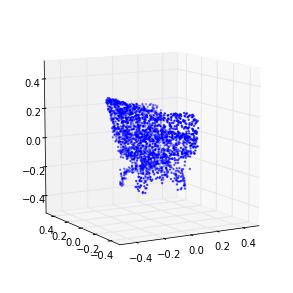

291 (-0.17321010082960128, -0.15236422585116494)
292 (-0.17247024062607025, -0.16476926455895105)
293 (-0.17184435272658313, -0.16262880464394888)
294 (-0.17100973228613536, -0.16566304365793863)
295 (-0.16887813171854726, -0.16258590420087179)
296 (-0.17188306379097479, -0.16229193933584071)
297 (-0.17226699447190319, -0.15875760631428826)
298 (-0.17035196859527518, -0.17634092492085915)
299 (-0.16801527247384743, -0.14997147327219998)
300 (-0.17066768882451233, -0.1486817369306529)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-300 is not in all_model_checkpoint_paths. Manually adding it.


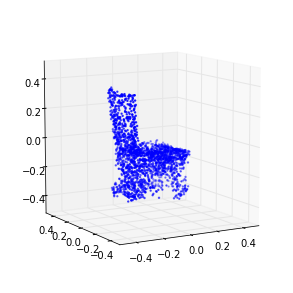

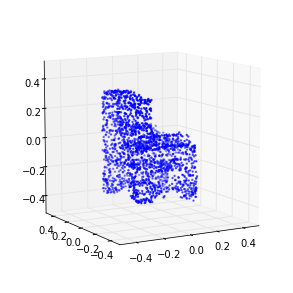

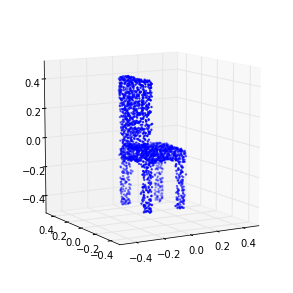

301 (-0.16895769304699368, -0.15074355155229568)
302 (-0.16890054822519973, -0.14456274553581519)
303 (-0.16782802221951662, -0.14986694466184686)
304 (-0.16896411931073224, -0.15590674733674084)
305 (-0.17151956469924362, -0.15131523901665653)
306 (-0.16798469777460451, -0.15757227661433043)
307 (-0.1697572006119622, -0.15616146116345017)
308 (-0.16996924601219318, -0.16002766236110968)
309 (-0.16963700690755137, -0.15506615738073984)
310 (-0.17028640420348556, -0.14720421036084494)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-310 is not in all_model_checkpoint_paths. Manually adding it.


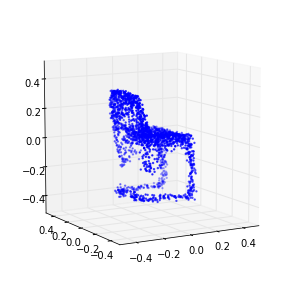

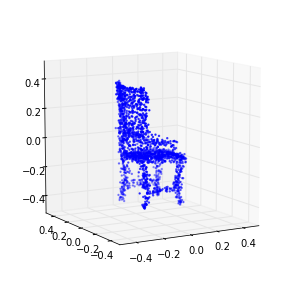

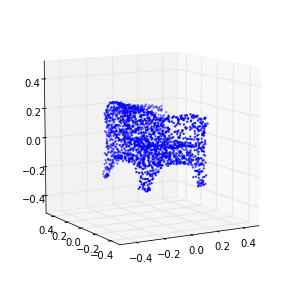

311 (-0.16996810381059294, -0.15467437715442092)
312 (-0.16901690220391308, -0.15271105534500545)
313 (-0.16674363453079152, -0.14500852619056348)
314 (-0.16722228129704794, -0.14819620135757658)
315 (-0.16657868794820926, -0.15759695017779315)
316 (-0.16890268988079496, -0.14660841088604043)
317 (-0.17025938348637687, -0.1529908867345916)
318 (-0.16647247324387232, -0.14850995220519878)
319 (-0.1672621531618966, -0.14121961538438443)
320 (-0.1681094511239617, -0.13115428056981829)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-320 is not in all_model_checkpoint_paths. Manually adding it.


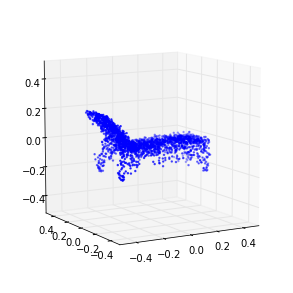

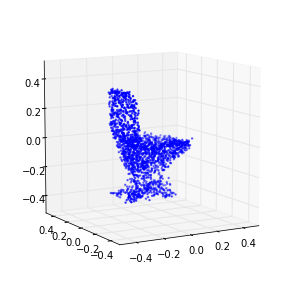

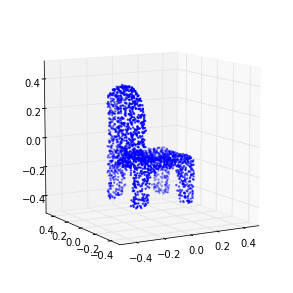

321 (-0.16792548171899938, -0.14619267428362812)
322 (-0.16826053786057013, -0.1324448361992836)
323 (-0.16659149549625538, -0.14379612770345476)
324 (-0.16683400985267427, -0.14171991414493984)
325 (-0.16820115248362225, -0.12818992331072135)
326 (-0.16860542783030757, -0.13260643184185028)
327 (-0.16811342355277803, -0.13881205408661454)
328 (-0.16607023946664951, -0.13546317319075266)
329 (-0.16787633498509724, -0.12962008240046324)
330 (-0.16761429972118802, -0.12010433773199718)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-330 is not in all_model_checkpoint_paths. Manually adding it.


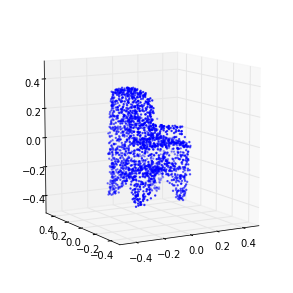

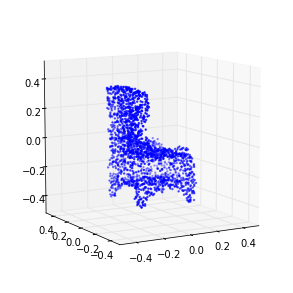

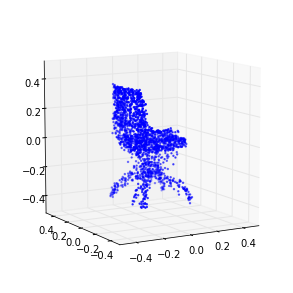

331 (-0.16624594529469808, -0.12705399206391088)
332 (-0.16230382168734514, -0.13247756853147788)
333 (-0.16759020840680158, -0.12362116492456859)
334 (-0.16642488671673669, -0.12102549136788757)
335 (-0.16539710765635526, -0.11675275089564147)
336 (-0.16957727974211728, -0.13267759813202751)
337 (-0.16707908731919749, -0.12346731098713698)
338 (-0.16804014322934327, -0.12293095941896792)
339 (-0.16770033113382482, -0.1309697542477537)
340 (-0.16887268606159422, -0.12622802125083077)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-340 is not in all_model_checkpoint_paths. Manually adding it.


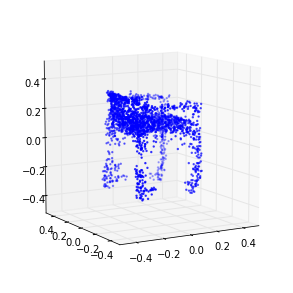

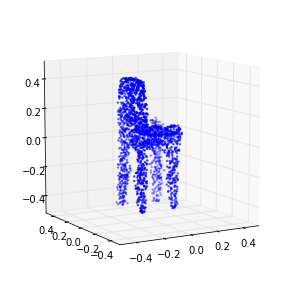

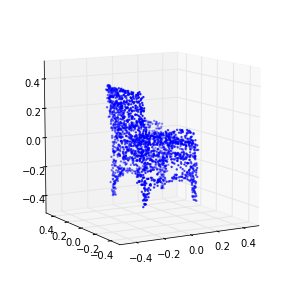

341 (-0.16829461549167279, -0.12693092033818917)
342 (-0.16726280792995735, -0.13239212913645637)
343 (-0.17024553208439439, -0.12921107312043509)
344 (-0.1668268930028986, -0.12954611772740329)
345 (-0.16835732504173562, -0.11641933934556113)
346 (-0.16807368281814788, -0.12482448584503597)
347 (-0.16967729495631323, -0.12995021459129122)
348 (-0.16738397561841542, -0.12892433835400474)
349 (-0.16687411108502634, -0.11831350514182339)
350 (-0.16777756385229253, -0.11846369118602187)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.


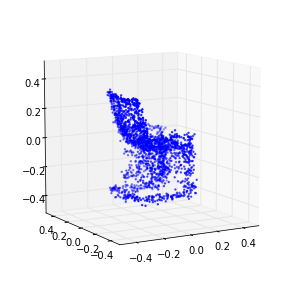

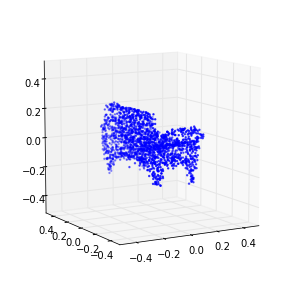

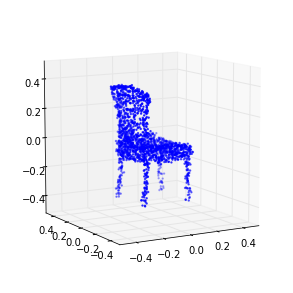

351 (-0.17127119931909773, -0.12658487674262789)
352 (-0.16605408224794599, -0.1123841639470171)
353 (-0.16782780422104729, -0.09994783949244905)
354 (-0.16705814136399164, -0.10615037795570162)
355 (-0.16625618073675369, -0.10770066799940886)
356 (-0.1642021248186076, -0.12116154062527197)
357 (-0.16779814815079724, -0.10717794409504643)
358 (-0.16470471714381818, -0.11196839533470294)
359 (-0.16543546208628901, -0.11523931487290948)
360 (-0.16536625055251297, -0.11259465029946079)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-360 is not in all_model_checkpoint_paths. Manually adding it.


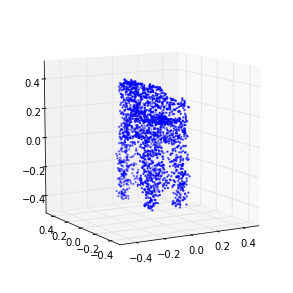

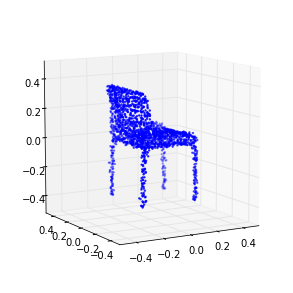

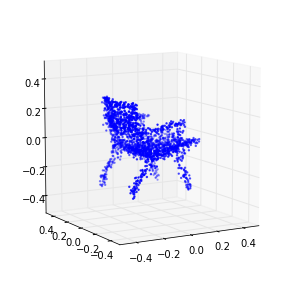

361 (-0.16859866027478818, -0.10785884630900842)
362 (-0.16790404076929447, -0.1066335581794933)
363 (-0.16691741838499352, -0.10242454900785729)
364 (-0.16655947383907105, -0.1069865193631914)
365 (-0.16886221082122238, -0.097218003675893505)
366 (-0.16957922086671548, -0.10763915021110464)
367 (-0.16578288519823992, -0.10927190355680606)
368 (-0.16890571735523366, -0.094237455891238317)
369 (-0.16605499259851597, -0.10249510986937417)
370 (-0.16774005498047229, -0.10173698404320965)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-370 is not in all_model_checkpoint_paths. Manually adding it.


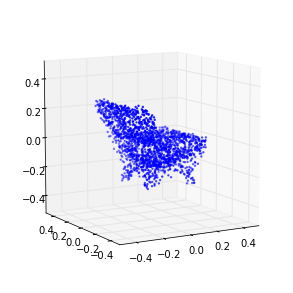

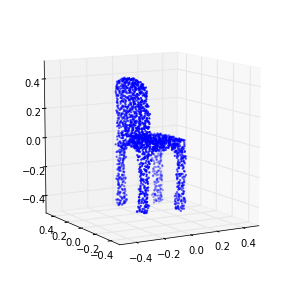

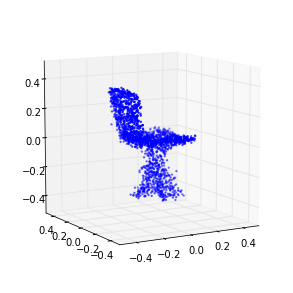

371 (-0.1688810517390569, -0.092966086334652365)
372 (-0.1656953760319286, -0.082506755297934567)
373 (-0.16717947544874967, -0.091080933602319822)
374 (-0.16508291661739349, -0.081342541095283299)
375 (-0.16567860245704652, -0.091733096236432041)
376 (-0.16486029873291652, -0.083689845960449288)
377 (-0.16654923365071969, -0.082734223317216943)
378 (-0.16698009057177438, -0.090170981293475186)
379 (-0.16681318481763205, -0.08271299564728031)
380 (-0.16761601959113723, -0.1014769540892707)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-380 is not in all_model_checkpoint_paths. Manually adding it.


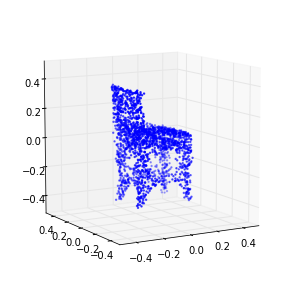

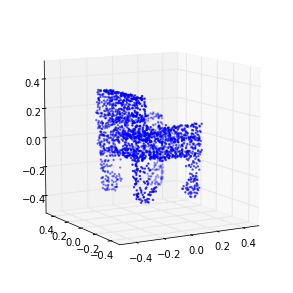

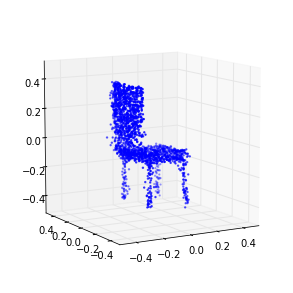

381 (-0.16661883774730896, -0.096124756391401639)
382 (-0.16665271802081003, -0.091138812678831602)
383 (-0.16768414251230382, -0.090883651127417878)
384 (-0.16593585097127492, -0.080992623749706477)
385 (-0.16809427870644464, -0.079669756952811172)
386 (-0.16577249020338058, -0.090320053751821866)
387 (-0.16876594424247743, -0.089915498677227229)
388 (-0.16556525313191944, -0.088397904540653577)
389 (-0.16556143114964167, -0.079439113261523073)
390 (-0.16454690319520457, -0.08302266081726109)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-390 is not in all_model_checkpoint_paths. Manually adding it.


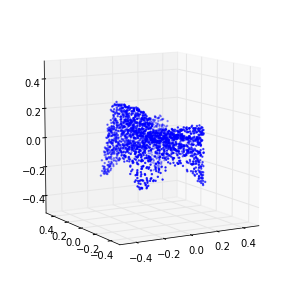

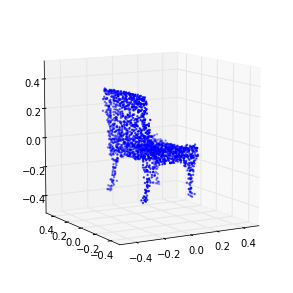

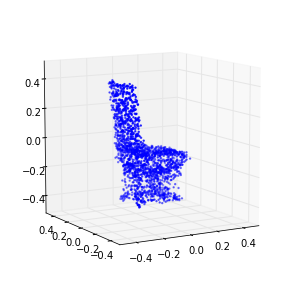

391 (-0.16718176603317261, -0.074247078073245501)
392 (-0.16623685564155932, -0.077690450750567297)
393 (-0.16509597632620071, -0.082003679402448515)
394 (-0.16650571171884185, -0.074437135916755159)
395 (-0.16594315270582835, -0.085147197461790503)
396 (-0.16525473473248659, -0.063037475812490334)
397 (-0.16796514629213899, -0.079856116324663162)
398 (-0.16659617396416487, -0.071154014517863587)
399 (-0.16603510644700792, -0.066155883483588696)
400 (-0.16607435875468785, -0.06641648806355617)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-400 is not in all_model_checkpoint_paths. Manually adding it.


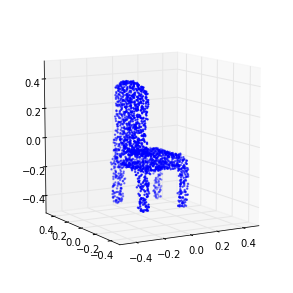

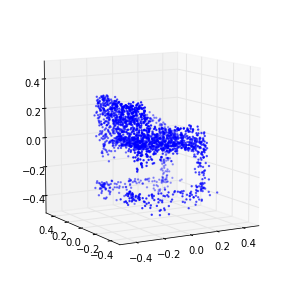

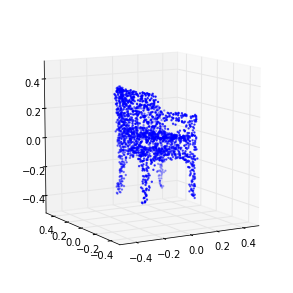

401 (-0.16891516110411398, -0.058787526907744234)
402 (-0.16783931271897423, -0.056729656678658945)
403 (-0.16819361442769015, -0.085587761882278651)
404 (-0.16870159297077744, -0.061763069661403144)
405 (-0.16463753581047058, -0.071764649064452554)
406 (-0.16404257240118802, -0.059145111590623856)
407 (-0.16377722786532509, -0.059179751926826105)
408 (-0.16282940137165564, -0.045693239955990402)
409 (-0.16361345267958111, -0.043486488534620511)
410 (-0.16610401774998065, -0.052368570153635961)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-410 is not in all_model_checkpoint_paths. Manually adding it.


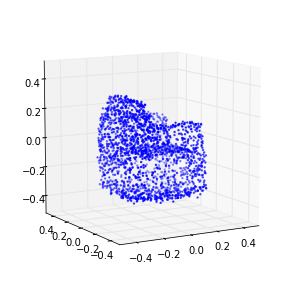

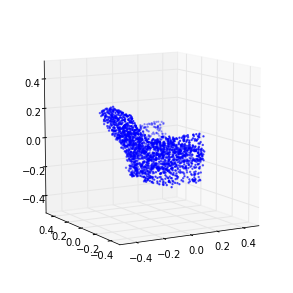

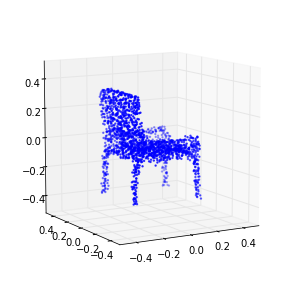

411 (-0.16506241079833772, -0.062037099152803421)
412 (-0.16777679732552281, -0.06378422721496059)
413 (-0.1676790107179571, -0.054232730840643249)
414 (-0.16928907086451847, -0.044643214265643445)
415 (-0.16553312032311052, -0.04838838166108838)
416 (-0.16715945965713924, -0.047835968469304067)
417 (-0.16400784077467742, -0.058178307143626387)
418 (-0.16510374380482568, -0.054198522569128764)
419 (-0.16483302889046847, -0.051944888093405299)
420 (-0.1655830708918748, -0.061474526714947492)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-420 is not in all_model_checkpoint_paths. Manually adding it.


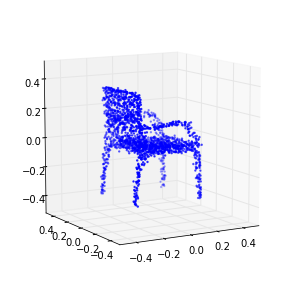

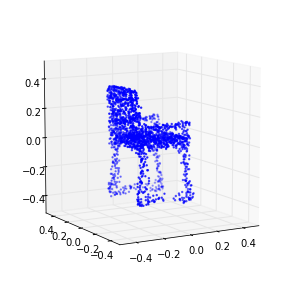

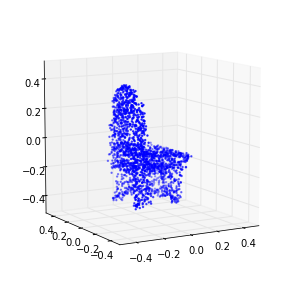

421 (-0.16826806018749874, -0.05109106069775643)
422 (-0.16628376526965036, -0.047480969379345574)
423 (-0.16542755155651659, -0.057719971191276004)
424 (-0.16440864740698427, -0.057693026683948656)
425 (-0.16813256475660537, -0.042267091261843838)
426 (-0.16342100865311093, -0.052462539325157799)
427 (-0.16956492403039225, -0.047195811514501217)
428 (-0.16583572780644451, -0.047430326161837136)
429 (-0.16655699919771266, -0.03967803606280574)
430 (-0.16423638457501377, -0.04260791206939353)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-430 is not in all_model_checkpoint_paths. Manually adding it.


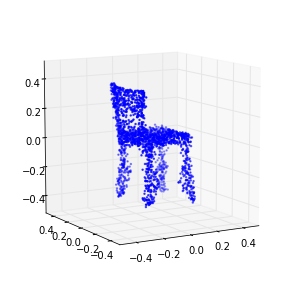

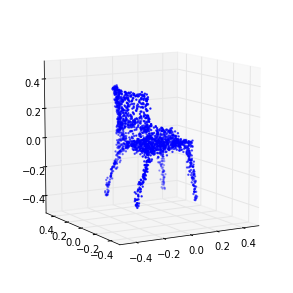

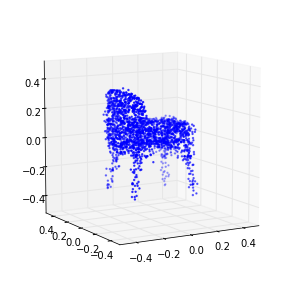

431 (-0.1675819910234875, -0.046118500814945611)
432 (-0.16793128997087478, -0.052355282388075637)
433 (-0.16239208308634934, -0.044926851177243168)
434 (-0.16843780058401603, -0.041063798608741271)
435 (-0.16592029465569391, -0.039912285490168467)
436 (-0.16495677707371889, -0.046788337485243879)
437 (-0.1644582979105137, -0.048144822733269796)
438 (-0.16623162963876018, -0.035547244207312666)
439 (-0.16612206217315462, -0.040595442712031027)
440 (-0.16633216192324957, -0.036575429762403168)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-440 is not in all_model_checkpoint_paths. Manually adding it.


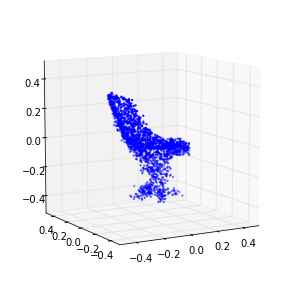

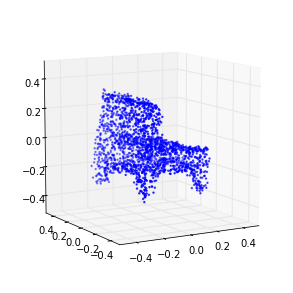

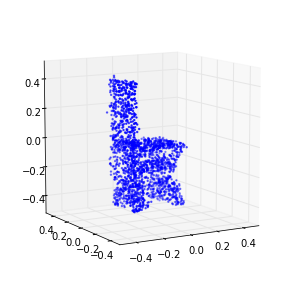

441 (-0.16930710055209972, -0.028524250908823753)
442 (-0.16580796992337263, -0.037039511198936788)
443 (-0.16317927164060098, -0.036345285466975637)
444 (-0.16242675328696216, -0.041882568047623393)
445 (-0.16791236698627471, -0.041106636118557721)
446 (-0.16522905556140122, -0.030556015187391528)
447 (-0.16482053459794432, -0.043761055054212059)
448 (-0.16434153036938773, -0.041397153158430698)
449 (-0.1683871860857363, -0.031040818740924198)
450 (-0.16429098938350326, -0.028192534145933611)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_11_emd_chair_2048_best_epoch/models.ckpt-450 is not in all_model_checkpoint_paths. Manually adding it.


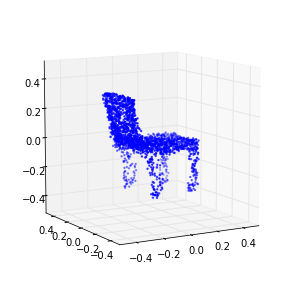

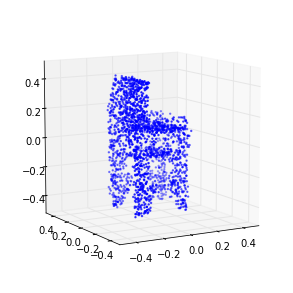

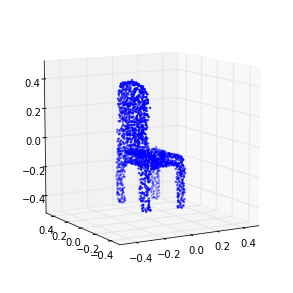

451 (-0.16828589472505781, -0.032511483274262259)
452 (-0.16602356991282216, -0.032271752582380069)
453 (-0.16638404511743121, -0.027394006873860403)
454 (-0.1707177174312097, -0.02437992892400534)
455 (-0.16759284767839644, -0.031808518994323631)
456 (-0.16773547044506779, -0.020055393317576359)
457 (-0.16558890993948336, -0.031940081018816541)
458 (-0.16711956494384342, -0.025182172026554192)
459 (-0.16488965799411137, -0.019845951452023454)


In [ ]:
save_dir = osp.join(synthetic_data_out_dir, experiment_name)
save_dir = create_dir(save_dir)

buf_size = 1 # flush each line
if do_training:    
    train_stats = []
    log_file = open(osp.join(train_dir, 'train_stats.txt'), 'a', buf_size)
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss                
        log_file.write('%04d\t%.9f\t%.9f\t%.4f\n' % (epoch, loss[0], loss[1], duration / 60.0))        

        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(save_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot(in_u_sphere=True)
                        
        train_stats.append((epoch,) + loss)
    log_file.close()

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('NB_WGAN_GP training. (%s, %s, %s-bneck)' %(class_name, ae_loss, ae.bottleneck_size))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')
    
    plt.savefig(osp.join(train_dir, 'training_curve.png'))